In [1]:
import yfinance
import numpy as np
import pandas as pd
import pandas
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

import cufflinks as cf
cf.set_config_file(offline=True)

import warnings
warnings.filterwarnings("ignore")


In [2]:
from ActMng import AccountManager

In [3]:
starting_capital = 100000
allocation = 0.8

symbol = 'SPY'

long_trend_days = 12
short_trend_days = 6

In [4]:
def fetch_data(symbol:str='SPY', start_date:str='2020', end_date:str=None):
    
    if end_date is None:
        end = pandas.Timestamp.now()
    else:
        end = end_date
    
    return pdr.get_data_yahoo(symbol, pandas.Timestamp(start_date), pandas.Timestamp(end))[['Open','Close']]
df = fetch_data(symbol)

[*********************100%***********************]  1 of 1 completed


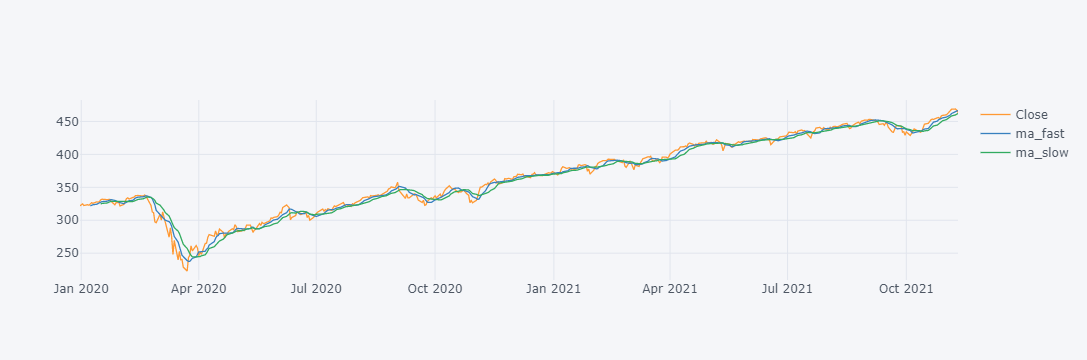

In [5]:
fast_trend = df.Open.rolling(window=short_trend_days).mean()
slow_trend = df.Open.rolling(window=long_trend_days).mean()

df['ma_fast'] = fast_trend
df['ma_slow'] = slow_trend
df[['Close','ma_fast','ma_slow']].iplot()

In [6]:
df['trade_direction'] = np.sign(fast_trend-slow_trend)
df

,Open,Close,ma_fast,ma_slow,trade_direction
Date,,,,,
2019-12-31,320.529999,321.859985,NaN,NaN,NaN
2020-01-02,323.540009,324.869995,NaN,NaN,NaN
2020-01-03,321.160004,322.410004,NaN,NaN,NaN
2020-01-06,320.489990,323.640015,NaN,NaN,NaN
2020-01-07,323.019989,322.730011,NaN,NaN,NaN
...,...,...,...,...,...
2021-11-04,465.359985,466.910004,459.751658,456.872498,1.0
2021-11-05,469.279999,468.529999,462.054993,458.384997,1.0
2021-11-08,469.700012,468.929993,464.359996,459.879166,1.0


In [7]:
#Determine the direction of the moving average differences
df_trades = df['trade_direction'].dropna().diff().dropna().apply(np.sign).astype('int8')
df_trades = pandas.DataFrame(df_trades[df_trades !=0])

#Label our intended trades
df_trades['trade'] = df['trade_direction'].map({1:'Long',-1:'Short'})
df['trades'] = df_trades['trade']


In [8]:
#Label our opening trade after removing our window period
df['trades'].replace(pandas.np.NaN,'None',inplace=True)
df = df.dropna()
df['trades'].iloc[0]=('Long' if df['trade_direction'].iloc[0]==1.0 else 'Short')
df

,Open,Close,ma_fast,ma_slow,trade_direction,trades
Date,,,,,,
2020-01-16,329.700012,330.920013,327.393341,324.670003,1.0,Long
2020-01-17,331.700012,331.950012,328.316676,325.600838,1.0,None
2020-01-21,330.899994,331.299988,328.918340,326.214170,1.0,None
2020-01-22,332.239990,331.339996,329.893336,327.137502,1.0,None
2020-01-23,330.630005,331.720001,330.420003,327.982503,1.0,None
...,...,...,...,...,...,...
2021-11-04,465.359985,466.910004,459.751658,456.872498,1.0,None
2021-11-05,469.279999,468.529999,462.054993,458.384997,1.0,None
2021-11-08,469.700012,468.929993,464.359996,459.879166,1.0,None


In [9]:
# Our trading strategy implementation - feel free to brose ActMng.py if you are curious.
trading_strategy = AccountManager(symbol=symbol,trades_df=df,starting_capital=starting_capital,allocation_amount=allocation)
results = trading_strategy.run()

In [10]:
#Here we can see a day by day breakdown of the account
results['result_df']

,Open,Close,ma_fast,ma_slow,trade_direction,trades,account_val,cash_bal,position,position_changes,fees
2020-01-16,329.700012,330.920013,327.393341,324.670003,1.0,Long,100295.021096,20000.589038,242.64,242.64,1.0
2020-01-17,331.700012,331.950012,328.316676,325.600838,1.0,None,100544.940000,20000.589038,242.64,0.00,0.0
2020-01-21,330.899994,331.299988,328.918340,326.214170,1.0,None,100387.218076,20000.589038,242.64,0.00,0.0
2020-01-22,332.239990,331.339996,329.893336,327.137502,1.0,None,100396.925750,20000.589038,242.64,0.00,0.0
2020-01-23,330.630005,331.720001,330.420003,327.982503,1.0,None,100489.130134,20000.589038,242.64,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-04,465.359985,466.910004,459.751658,456.872498,1.0,None,136027.695666,25682.854500,236.33,0.00,0.0
2021-11-05,469.279999,468.529999,462.054993,458.384997,1.0,None,136410.549112,25682.854500,236.33,0.00,0.0
2021-11-08,469.700012,468.929993,464.359996,459.879166,1.0,None,136505.079669,25682.854500,236.33,0.00,0.0
2021-11-09,469.320007,467.380005,465.863332,461.228333,1.0,None,136138.771054,25682.854500,236.33,0.00,0.0


In [11]:
# Here are our simulated orders as we would submit to an API endpoint for algorthmic trading. 
results['broker_orders']

,symbol,date,time,order,order_type,price,size,exchange_fees
2020-01-16,SPY,2020-01-16 00:00:00,At Market Open,BUY,MARKET,329.700012,242.64,1.0
2020-01-29,SPY,2020-01-29 00:00:00,At Market Open,SELL,MARKET,328.380005,242.64,1.0
2020-01-29,SPY,2020-01-29 00:00:00,At Market Open,SELL,MARKET,328.380005,242.84,1.0
2020-02-07,SPY,2020-02-07 00:00:00,At Market Open,BUY,MARKET,332.820007,242.84,1.0
2020-02-07,SPY,2020-02-07 00:00:00,At Market Open,BUY,MARKET,332.820007,237.00,1.0
...,...,...,...,...,...,...,...,...
2021-09-14,SPY,2021-09-14 00:00:00,At Market Open,SELL,MARKET,448.119995,223.86,1.0
2021-09-14,SPY,2021-09-14 00:00:00,At Market Open,SELL,MARKET,448.119995,223.90,1.0
2021-10-13,SPY,2021-10-13 00:00:00,At Market Open,BUY,MARKET,434.709991,223.90,1.0
2021-10-13,SPY,2021-10-13 00:00:00,At Market Open,BUY,MARKET,434.709991,236.33,1.0


In [12]:
r= results['result_df']

35.3
0.2
0.9929610392470064


<AxesSubplot:>

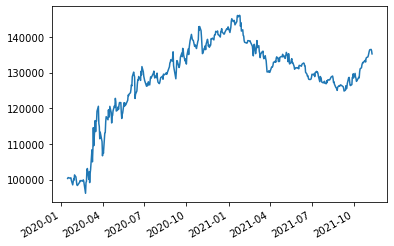

In [13]:
#Todo:
# Calculate the Absolute Return of our trend-following trading strategy
absolute_return_tf =((r['account_val'].iloc[-1]- starting_capital)/starting_capital)*100
print (absolute_return_tf.round(1))
# Calculate the CAGR or our trend-following trading strategy
CAGR_tf = ((r['account_val'].iloc[-1]/starting_capital)**(252/len(df)))-1
print (CAGR_tf.round(1))
# Calculate the IR (Sharpe without RF-rate) of our trend-following trading strategy
information_ratio_tf = (r.account_val.pct_change().mean()/r.account_val.pct_change().std())*((252)**0.5)
print (information_ratio_tf)
#Plot the equity curve (hint: use 'account_val')
r.account_val.plot()

<AxesSubplot:>

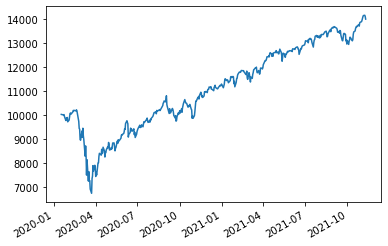

In [14]:
#Todo:
# Calculate the Absolute Return of a buy-and-hold strategy in the same period
absolute_return_bh = r.Close.iloc[-1]-r.Open.iloc[0]/r.Open.iloc[0]
# Calculate the CAGR or our trend-following trading strategy
CAGR_bh = ((r.Close.iloc[-1]/r.Open.iloc[0]**252/len(df)))-1
# Calculate the IR (Sharpe without RF-rate) of our trend-following trading strategy
information_ratio_bh = (r.account_val.pct_change().mean()/r.account_val.pct_change().std())*((252**0.5))


#Plot the equity curve (hint: use 'close' returns and your initial capital value to generate an equity curve)
((r.Close.pct_change().dropna()+1).cumprod()*10000).plot()

In [15]:
#Todo - optional, below:
# Copy any of the code from above to new cells below, and see how changing the symbol, dates and trend parameters changes the performance
# Can you beat the reference implementation?

starting_capital = 200000
allocation = 0.7

symbol = 'BTC'

long_trend_days = 12
short_trend_days = 6

In [16]:
def fetch_data(symbol:str='BTC', start_date:str='2020', end_date:str=None):
    
    if end_date is None:
        end = pandas.Timestamp.now()
    else:
        end = end_date
    
    return pdr.get_data_yahoo(symbol, pandas.Timestamp(start_date), pandas.Timestamp(end))[['Open','Close']]
df = fetch_data(symbol)

[*********************100%***********************]  1 of 1 completed


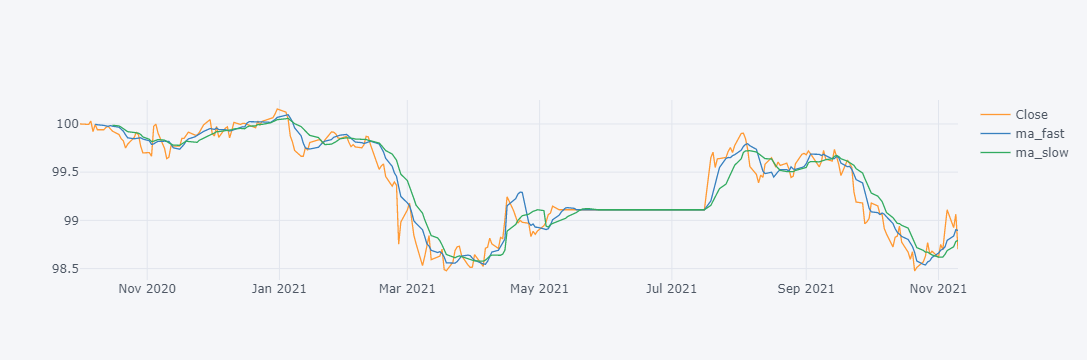

In [17]:
fast_trend = df.Open.rolling(window=short_trend_days).mean()
slow_trend = df.Open.rolling(window=long_trend_days).mean()

df['ma_fast'] = fast_trend
df['ma_slow'] = slow_trend
df[['Close','ma_fast','ma_slow']].iplot()

In [18]:
df['trade_direction'] = np.sign(fast_trend-slow_trend)
df

,Open,Close,ma_fast,ma_slow,trade_direction
Date,,,,,
2020-10-01,100.000000,100.000000,NaN,NaN,NaN
2020-10-02,100.000000,100.000000,NaN,NaN,NaN
2020-10-05,100.029999,99.995003,NaN,NaN,NaN
2020-10-06,100.010002,100.029999,NaN,NaN,NaN
2020-10-07,99.949997,99.919998,NaN,NaN,NaN
...,...,...,...,...,...
2021-11-04,98.910103,98.910103,98.725117,98.647141,1.0
2021-11-05,99.044998,99.110001,98.792617,98.686724,1.0
2021-11-08,98.949997,98.925003,98.837516,98.726308,1.0


In [19]:
#Determine the direction of the moving average differences
df_trades = df['trade_direction'].dropna().diff().dropna().apply(np.sign).astype('int8')
df_trades = pandas.DataFrame(df_trades[df_trades !=0])

#Label our intended trades
df_trades['trade'] = df['trade_direction'].map({1:'Long',-1:'Short'})
df['trades'] = df_trades['trade']

In [20]:
#Label our opening trade after removing our window period
df['trades'].replace(pandas.np.NaN,'None',inplace=True)
df = df.dropna()
df['trades'].iloc[0]=('Long' if df['trade_direction'].iloc[0]==1.0 else 'Short')
df

,Open,Close,ma_fast,ma_slow,trade_direction,trades
Date,,,,,,
2020-10-16,99.949997,99.925003,99.976499,99.986582,-1.0,Short
2020-10-19,99.910004,99.889999,99.966499,99.979083,-1.0,None
2020-10-20,99.847099,99.847099,99.947683,99.966341,-1.0,None
2020-10-21,99.839996,99.824303,99.924516,99.950507,-1.0,None
2020-10-22,99.779999,99.750000,99.887849,99.931341,-1.0,None
...,...,...,...,...,...,...
2021-11-04,98.910103,98.910103,98.725117,98.647141,1.0,None
2021-11-05,99.044998,99.110001,98.792617,98.686724,1.0,None
2021-11-08,98.949997,98.925003,98.837516,98.726308,1.0,None


In [21]:
# Our trading strategy implementation - feel free to brose ActMng.py if you are curious.
trading_strategy = AccountManager(symbol=symbol,trades_df=df,starting_capital=starting_capital,allocation_amount=allocation)
results = trading_strategy.run()

In [22]:
#Here we can see a day by day breakdown of the account
results['result_df']

,Open,Close,ma_fast,ma_slow,trade_direction,trades,account_val,cash_bal,position,position_changes,fees
2020-10-16,99.949997,99.925003,99.976499,99.986582,-1.0,Short,200034.008951,339998.960725,-1400.70,-1400.70,1.0
2020-10-19,99.910004,99.889999,99.966499,99.979083,-1.0,None,200083.038580,339998.960725,-1400.70,0.00,0.0
2020-10-20,99.847099,99.847099,99.947683,99.966341,-1.0,None,200143.128730,339998.960725,-1400.70,0.00,0.0
2020-10-21,99.839996,99.824303,99.924516,99.950507,-1.0,None,200175.059971,339998.960725,-1400.70,0.00,0.0
2020-10-22,99.779999,99.750000,99.887849,99.931341,-1.0,None,200279.135725,339998.960725,-1400.70,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-04,98.910103,98.910103,98.725117,98.647141,1.0,None,201569.319072,60367.234454,1427.58,0.00,0.0
2021-11-05,99.044998,99.110001,98.792617,98.686724,1.0,None,201854.689125,60367.234454,1427.58,0.00,0.0
2021-11-08,98.949997,98.925003,98.837516,98.726308,1.0,None,201590.590310,60367.234454,1427.58,0.00,0.0
2021-11-09,99.064003,99.064003,98.903183,98.781641,1.0,None,201789.023843,60367.234454,1427.58,0.00,0.0


In [23]:
# Here are our simulated orders as we would submit to an API endpoint for algorthmic trading. 
results['broker_orders']

,symbol,date,time,order,order_type,price,size,exchange_fees
2020-10-16,BTC,2020-10-16 00:00:00,At Market Open,SELL,MARKET,99.949997,1400.70,1.0
2020-11-11,BTC,2020-11-11 00:00:00,At Market Open,BUY,MARKET,99.668999,1400.70,1.0
2020-11-11,BTC,2020-11-11 00:00:00,At Market Open,BUY,MARKET,99.668999,1407.40,1.0
2020-11-12,BTC,2020-11-12 00:00:00,At Market Open,SELL,MARKET,99.789001,1407.40,1.0
2020-11-12,BTC,2020-11-12 00:00:00,At Market Open,SELL,MARKET,99.789001,1406.88,1.0
2020-11-19,BTC,2020-11-19 00:00:00,At Market Open,BUY,MARKET,99.889999,1406.88,1.0
2020-11-19,BTC,2020-11-19 00:00:00,At Market Open,BUY,MARKET,99.889999,1404.45,1.0
2020-12-08,BTC,2020-12-08 00:00:00,At Market Open,SELL,MARKET,100.009003,1404.45,1.0
2020-12-08,BTC,2020-12-08 00:00:00,At Market Open,SELL,MARKET,100.009003,1403.93,1.0
2020-12-14,BTC,2020-12-14 00:00:00,At Market Open,BUY,MARKET,100.018997,1403.93,1.0


In [24]:
r= results['result_df']

0.6
0.0
0.508257816272379


<AxesSubplot:>

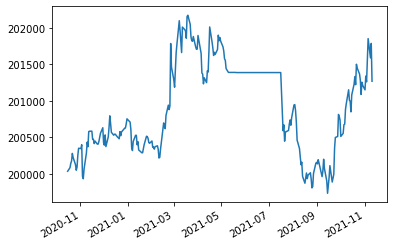

In [25]:
#Todo:
# Calculate the Absolute Return of our trend-following trading strategy
absolute_return_tf =((r['account_val'].iloc[-1]- starting_capital)/starting_capital)*100
print (absolute_return_tf.round(1))
# Calculate the CAGR or our trend-following trading strategy
CAGR_tf = ((r['account_val'].iloc[-1]/starting_capital)**(252/len(df)))-1
print (CAGR_tf.round(1))
# Calculate the IR (Sharpe without RF-rate) of our trend-following trading strategy
information_ratio_tf = (r.account_val.pct_change().mean()/r.account_val.pct_change().std())*((252)**0.5)
print (information_ratio_tf)
#Plot the equity curve (hint: use 'account_val')
r.account_val.plot()

<AxesSubplot:>

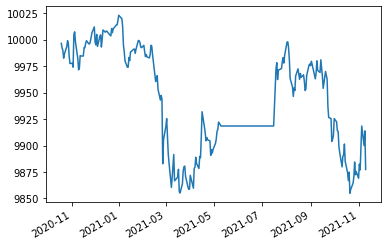

In [28]:
#Todo:
# Calculate the Absolute Return of a buy-and-hold strategy in the same period
absolute_return_bh = r.Close.iloc[-1]-r.Open.iloc[0]/r.Open.iloc[0]
# Calculate the CAGR or our trend-following trading strategy
CAGR_bh = ((r.Close.iloc[-1]-r.Open.iloc[0]**252/len(df)))-1
# Calculate the IR (Sharpe without RF-rate) of our trend-following trading strategy
information_ratio_bh = (r.account_val.pct_change().mean()/r.account_val.pct_change().std())*((252**0.5))


#Plot the equity curve (hint: use 'close' returns and your initial capital value to generate an equity curve)
((r.Close.pct_change().dropna()+1).cumprod()*10000).plot()